In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from PIL import Image
from numpy import asarray

In [ ]:
df = pd.read_csv('facial_keypoints.csv')
df.head()

In [ ]:
df = df.fillna(0)

In [ ]:
c = 0
columns = {}
temp = []
for i, e in enumerate(list(df.columns)):
    temp.append(e)
    c += 1
    if c == 2:
        columns[e.split('_y')[0]] = temp
        temp = []
        c = 0

In [ ]:
keypoints_dict = {}
for k in columns.keys():
    keypoints_dict[k] = df[columns[k]].values

keypoints = np.array(list(keypoints_dict.values()))
keypoints = np.swapaxes(keypoints, 0, 1)
features = np.load('face_images.npz')['face_images']
features = np.swapaxes(np.swapaxes(features, 1, 2), 0, 1)
print(keypoints[0])

In [ ]:
def display_image_keypoints(features, keypoints):
    fig = plt.figure()
    plt.imshow(features)
    for i in range(keypoints.shape[1]):
        element = keypoints[i]
        plt.scatter(element[0],element[1],c='r',s=12)
    fig.savefig('masked.png')

In [ ]:
keypoints = keypoints.reshape(-1, 30)
features = features.reshape(7049, 96, 96, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, keypoints, test_size=0.1)
img_size = 96

In [ ]:
model = Sequential()
model.add(Input(shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  

model.add(Flatten())
model.add(Dense(128,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5)) 

model.add(Dense(64,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0))

model.add(Dense(30,kernel_initializer=glorot_uniform()))
checkpoint_filepath = 'weights.{epoch:02d}-{accuracy:.2f}.h5'
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mean_squared_error', 'accuracy'])
mcc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    callbacks=[mcc]
)

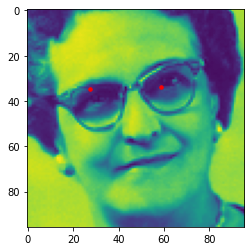

In [208]:
model.load_weights("weights.11-0.87.h5")
#Trying out the recognition on the 120th training image
kp = model.predict(X_train[1400].reshape(1, 96, 96, 1))
kp = kp.reshape(15, 2)
display_image_keypoints(X_train[1400].reshape(96, 96, 1), kp)
p1 = kp[0]
p2 = kp[1]
center_x = (p1[0] + p2[0])//2
center_y = (p1[0] + p2[0])//2
tm = Image.open("masked.png")
mt = Image.open("mask.png")
mt = mt.resize((tm.width//3, tm.height//3))
tm.paste(mt, (int(center_x)+tm.width//5, int(center_y) + tm.height//3), mt)
tm.save("with_mask.png")
tm.show()

In [ ]:
model.load_weights("weights.0.90.h5")
a = features[0].reshape(1, 96, 96, 1)

b = keypoints[0]
print(model.predict(a))
print(b)